In [3]:
#Model, dataloader
from sklearn.decomposition import IncrementalPCA
import numpy as np
import importlib
import utils
from tqdm import tqdm
import torch
import torch.nn as nn
import joblib
importlib.reload(utils)
device="cuda"
batch_size=4096
save_name="save_14_to_17-10-25"
data_path="/home/adam/source/CLIP/full_dataset_embeddings.h5"

dataloader, _ =utils.dataloader_emb(data_path,batch_size=batch_size)
#hyperparameters:
#pos. layer sizes
#we first upscale from 2 to dim_fourrier_encoding, with the fourrier encodding
dim_fourier_encoding=64 #multiple of 4!!
dim_hidden=256
dim_emb=128 #this one is actually shared with img embeddings

#dim image layer size: 
#As of now: linear from 768 to dim_emb. We could also have MLP if non-linearity needed


image_encoder=nn.Linear(768,dim_emb).to(device)
pos_encoder=utils.Fourier_MLP(original_dim=2, fourier_dim=dim_fourier_encoding, hidden_dim=dim_hidden, output_dim=dim_emb).to(device)
model= utils.DoubleNetwork(image_encoder,pos_encoder).to(device)
img_enc=model.image_encoder

/home/adam/anaconda3/envs/CLIP/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#PCA
from sklearn.decomposition import PCA
import torch
import joblib
from sklearn.preprocessing import StandardScaler
dataloader=tqdm(dataloader)
def perform_IPCA(dataloader, img_enc,device="cuda",file_name="pca_model",n_components=None):
    '''Charge  the .kle file with: pca_model = joblib.load('pca_model.pkl')   '''
    ipca = IncrementalPCA(n_components=n_components)
    for embeddings, labels in dataloader:   # batch is (batch_size, nbr_features)
        embeddings=embeddings.to(device)
        embeddings=img_enc(embeddings) #we want the actual 128 encoded vectors
        scaler = StandardScaler()
        scaler.fit(embeddings)
        embeddings = scaler.transform(embeddings)
        ipca.partial_fit(embeddings.detach().cpu().numpy())
    joblib.dump(ipca, file_name + '.pkl')



def perform_PCA(dataloader, img_enc, device="cuda", file_name="pca_model", n_components=None):
    """load with pca_model = joblib.load('pca_model.pkl')"""
    all_embeddings = []

    for embeddings, labels in dataloader:
        embeddings = embeddings.to(device)
        embeddings = img_enc(embeddings)  # get the actual encoded vectors
        all_embeddings.append(embeddings.detach().cpu().numpy())

    all_embeddings = np.vstack(all_embeddings)

    pca = PCA(n_components=n_components)
    pca.fit(all_embeddings)
    joblib.dump(pca, file_name + '.pkl')

#erform_PCA(dataloader, img_enc=img_enc, file_name="pca_model")


pca_loaded = joblib.load('PCA_All_comp_full_dataset_Normalized.pkl')
components = pca_loaded.components_
explained_variance = pca_loaded.explained_variance_


def coord_to_PCA(coords, pos_enc,pca_model_path):  #coordinates of the embbeddings in the PCA basis
    pca_model=joblib.load(pca_model_path)
    embeddings=pos_enc(coords)
    vect_to_plot = pca_model.transform(embeddings)
    return vect_to_plot

explained_variance=explained_variance/explained_variance.sum() # proportions

  0%|          | 0/619 [00:00<?, ?it/s]

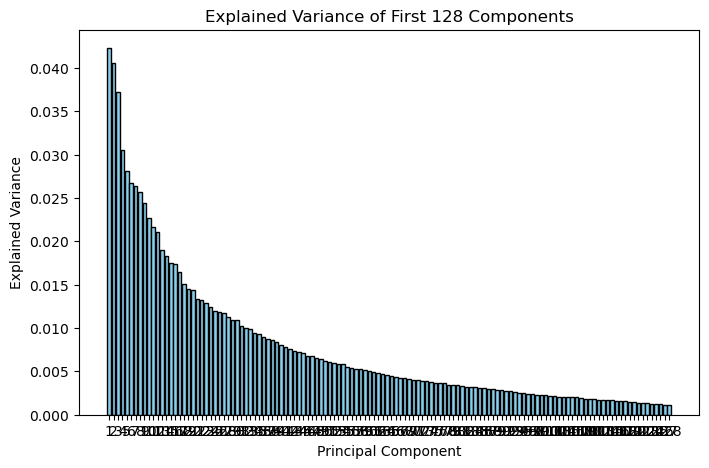

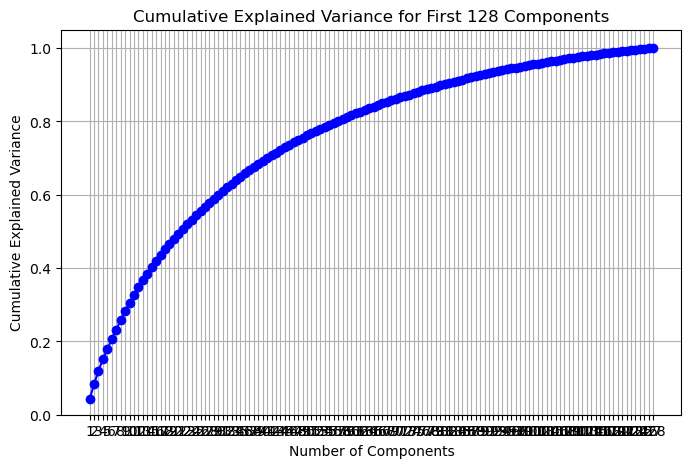

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Number of components to plot
k = 128

# Select the first k components
components = np.arange(1, k+1)
variance_to_plot = explained_variance[:k]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(components, variance_to_plot, color='skyblue', edgecolor='black')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title(f'Explained Variance of First {k} Components')
plt.xticks(components)
plt.show()

cumulative_variance = np.cumsum(explained_variance[:k])

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, k+1), cumulative_variance, marker='o', linestyle='-', color='b')
plt.title(f'Cumulative Explained Variance for First {k} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, k+1))
plt.yticks(np.linspace(0, 1, 6))  # 0, 0.2, 0.4, ..., 1
plt.ylim(0, 1.05)
plt.grid(True)
